# BCM visualisation

Sun Woo P. Kim and Kenza Tazi

In [ ]:
import sys
import json

import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from scipy.special import erf
from cartopy.io import shapereader
from matplotlib.patches import Rectangle, ConnectionPatch

In [ ]:
DIR = json.load(open("../../config.json"))["code_dir"]
sys.path.append(DIR)  # noqa
from load import data_dir
from bcm4rcm.utils.areal_plots import regional_rectangle

## Test plots

In [ ]:
# Load data
a = pd.read_csv("../../data/processed/historical/historical_CSIRO_RegCM4_1951_1975.csv")
b = pd.read_csv("../../data/processed/historical/historical_CSIRO_RegCM4_1976_2005.csv")
c = pd.read_csv(
    "../../data/bcm_outputs/historical/bcm_historical_CSIRO_RegCM4_1951_2005.csv"
)
lamb = np.load(
    "../../data/bcm_outputs/historical/lambda_historical_CSIRO_RegCM4_1981_2005.npy"
)

/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_37798/778619605.py:15: RuntimeWarning: divide by zero encountered in power
  return y**(lambda_ - 1)/np.sqrt(2*np.pi*var)*np.exp(-((y**lambda_ - 1)/lambda_ - mean)**2/(2*var))/C


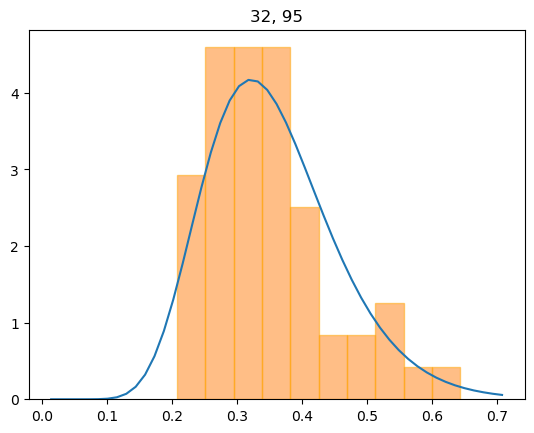

In [ ]:
# Try plotting some histograms
a_interested = a.loc[
    (a["lat"] == 32.25)
    & (a["lon"] == 95.25)
    & (a["lon"] == 95.25)
    & (a.apply(lambda x: (x["time"].split("-")[1] == "02"), axis=1))
]
b_interested = b.loc[
    (b["lat"] == 32.25)
    & (b["lon"] == 95.25)
    & (b["lon"] == 95.25)
    & (b.apply(lambda x: (x["time"].split("-")[1] == "02"), axis=1))
]

tp1 = list(a_interested["tp"]) + list(b_interested["tp"])
c_interested = c.loc[(c["lat"] == 32.125) & (c["lon"] == 95.125) & (c["month"] == 2.0)]

var = float(c_interested["var"].iloc[0])
mean = float(c_interested["mean"].iloc[0])


C = 0.5 * (1 + erf((1 / lamb + mean) / np.sqrt(2 * var)))


def p(y, lambda_, mean, var, C):
    return (
        y ** (lambda_ - 1)
        / np.sqrt(2 * np.pi * var)
        * np.exp(-(((y**lambda_ - 1) / lambda_ - mean) ** 2) / (2 * var))
        / C
    )


plt.title(f"32, 95")
x1 = np.linspace(0, 1.1 * max(tp1))
y1 = p(x1, lamb, mean, var, C)

plt.plot(x1, y1)
plt.hist(tp1, bins=10, density=True, alpha=0.5, edgecolor="orange")

/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_37798/767492390.py:17: RuntimeWarning: divide by zero encountered in power
  return y**(lambda_ - 1)/np.sqrt(2*np.pi*var)*np.exp(-((y**lambda_ - 1)/lambda_ - mean)**2/(2*var))/C


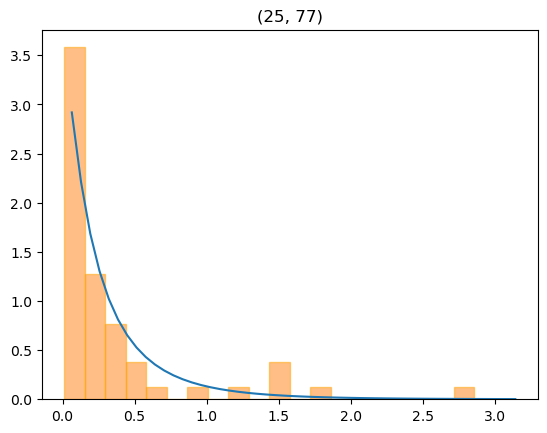

In [ ]:
ss = 77
dd = 25

a_interested = a.loc[
    (a["lat"] == dd + 0.25)
    & (a["lon"] == ss + 0.25)
    & (a.apply(lambda x: (x["time"].split("-")[1] == "02"), axis=1))
]
b_interested = b.loc[
    (b["lat"] == dd + 0.25)
    & (b["lon"] == ss + 0.25)
    & (b.apply(lambda x: (x["time"].split("-")[1] == "02"), axis=1))
]

tp2 = list(a_interested["tp"]) + list(b_interested["tp"])
c_interested = c.loc[
    (c["lat"] == dd + 0.125) & (c["lon"] == ss + 0.125) & (c["month"] == 2.0)
]

var = float(c_interested["var"].iloc[0])
mean = float(c_interested["mean"].iloc[0])

C = 0.5 * (1 + erf((1 / lamb + mean) / np.sqrt(2 * var)))


def p(y, lambda_, mean, var, C):
    return (
        y ** (lambda_ - 1)
        / np.sqrt(2 * np.pi * var)
        * np.exp(-(((y**lambda_ - 1) / lambda_ - mean) ** 2) / (2 * var))
        / C
    )


x2 = np.linspace(0, 1.1 * max(tp2))
y2 = p(x2, lamb, mean, var, C)

plt.title("(25, 77)")
plt.plot(x2, y2)
plt.hist(tp2, bins=20, density=True, alpha=0.5, edgecolor="orange")

## Load and process data

In [ ]:
a = pd.read_csv("../../data/processed/aphro_1951_2005.csv")

n_lat = 88
n_lon = 200
n_month = 12
n_year = 55

n_lat_rcm = 80
n_lon_rcm = 180


lats = np.array(a["lat"]).reshape(n_year, n_month, n_lon, n_lat)[0, 0, 0, :n_lat_rcm]
lons = np.array(a["lon"]).reshape(n_year, n_month, n_lon, n_lat)[0, 0, :n_lon_rcm, 0]
months = np.array(a["month"]).reshape(n_year, n_month, n_lon, n_lat)[0, :, 0, 0]
years = np.array([int(i.split("-")[0]) for i in list(a["time"])]).reshape(
    n_year, n_month, n_lon, n_lat
)[:, 0, 0, 0]

lats_l = list(lats)
lons_l = list(lons)
months_l = list(months)
years_l = list(years)

i_2005 = years_l.index(2005)

tps = np.array(a["tp"]).reshape(n_year, n_month, n_lon, n_lat)[
    : i_2005 + 1, :, :n_lon_rcm, :n_lat_rcm
]
years_l = years_l[: i_2005 + 1]
years = years[: i_2005 + 1]

del a

In [ ]:
rcm_data = pd.read_csv(
    f"../../data/bcm_outputs/historical/bcm_historical_CSIRO_RegCM4_1951_2005.csv"
)

means = np.full((n_month, n_lon_rcm, n_lat_rcm), np.nan)
vars = np.full((n_month, n_lon_rcm, n_lat_rcm), np.nan)

for i in range(rcm_data.shape[0]):
    i_lat = lats_l.index(rcm_data.iloc[i]["lat"])
    i_lon = lons_l.index(rcm_data.iloc[i]["lon"])
    i_month = months_l.index(rcm_data.iloc[i]["month"])

    mean = np.array(rcm_data.iloc[i]["mean"])
    var = np.array(rcm_data.iloc[i]["var"])

    means[i_month, i_lon, i_lat] = mean
    vars[i_month, i_lon, i_lat] = var

del rcm_data

## Plotting tools

In [ ]:
def indicate_inset(fig, axin, axout, arrow_start=(0, 0), arrow_end=(0, 0)):
    """Indicate how to draw the inset and its connectors to the main plot"""
    (x0, x1), (y0, y1) = axin.get_xlim(), axin.get_ylim()
    width = x1 - x0
    height = y1 - y0
    rect = Rectangle(
        [x0, y0],
        width=width,
        height=height,
        transform=axout.transData,
        fc="none",
        ec="orange",
    )
    axout.add_patch(rect)
    conn = ConnectionPatch(
        xyA=arrow_start,
        coordsA=rect.get_transform(),
        xyB=arrow_end,
        coordsB=axin.transAxes,
        color="orange",
        arrowstyle="->",
    )
    fig.add_artist(conn)
    return rect, conn

In [ ]:
# Cartopy objects
proj = ccrs.PlateCarree()
ocean_50m = cf.NaturalEarthFeature(
    "physical", "ocean", "50m", edgecolor="darkgrey", facecolor="white"
)

In [ ]:
# Subregions
hma1 = regional_rectangle(71, 79, 32, 39)
hma2 = regional_rectangle(76, 93, 27, 32)
hma3 = regional_rectangle(93, 103, 28, 36)
region_dict2 = {
    "HMA1": [71.5, 38],
    "HMA2": [76.5, 31],
    "HMA3": [93.5, 35],
}

In [20]:
# HKH region
hkh_region_path = data_dir + "Shapefiles/hkh/outline.shp"
hkh_region_shape = shapereader.Reader(hkh_region_path)
hkh_region_globe = ccrs.Globe(semimajor_axis=6377276.345, inverse_flattening=300.8017)
hkh_region = ccrs.PlateCarree()

## Visualisation

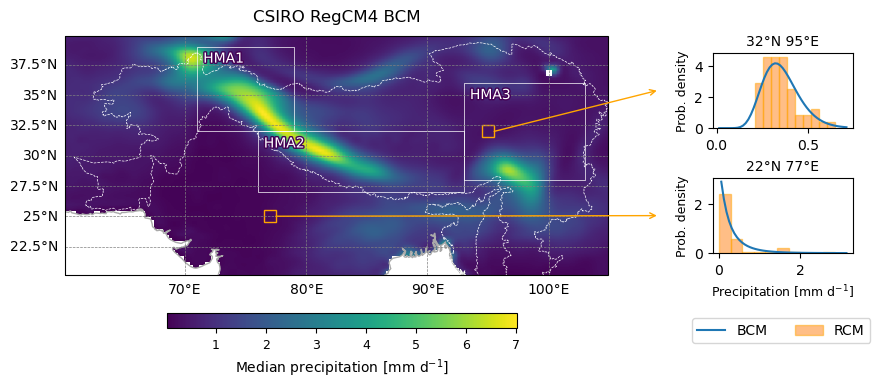

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[7, 5], subplot_kw={"projection": proj})

## Main plot
im = ax.imshow(
    ((lamb * means[1] + 1) ** (1 / lamb) * (0 * tps[-1, 1] + 1)).T,
    origin="lower",
    extent=(min(lons), max(lons), min(lats), max(lats)),
    zorder=-10,
)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle="--", color="gray")
gl.top_labels = False
gl.right_labels = False
ax.add_feature(ocean_50m, zorder=-9)
ax.text(
    0.5,
    1.08,
    "CSIRO RegCM4 BCM",
    fontsize=12,
    transform=ax.transAxes,
    ha="center",
    va="center",
    rasterized=True,
)

# HKH boundaries
for rec in hkh_region_shape.records():
    ax.add_geometries(
        [rec.geometry],
        hkh_region,
        edgecolor="white",
        facecolor="None",
        linestyle="--",
        linewidth=0.5,
        zorder=-8,
    )

# Mountain boundaries
ax.add_geometries(
    [hma1, hma2, hma3],
    proj,
    edgecolor="white",
    facecolor="None",
    linestyle="-",
    linewidth=0.5,
)

# Colorbar
cax = plt.axes(
    [0.27, 0.15, 0.5, 0.03],
)
cb = fig.colorbar(
    im, cax=cax, pad=0.0, location="bottom", label=r"Median precipitation [mm d$^{-1}$]"
)
cb.ax.tick_params(labelsize=9)

### Inset 1
axins1 = ax.inset_axes(
    [1.05, 0.55, 0.2, 0.15],
    xlim=(95 - 0.5, 95 + 0.5),
    ylim=(32 - 0.5, 32 + 0.5),
    xticklabels=[],
    yticklabels=[],
    transform=fig.transFigure,
)
axins1.set_axis_off()
axins1.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    labelbottom=False,
    right=False,
    left=False,
    labelleft=False,
)
indicate_inset(fig, axins1, ax, arrow_start=(1, 0.5), arrow_end=(-0.4, 0.5))

axinsr1 = fig.add_axes([1.05, 0.55, 0.2, 0.15])
axinsr1.set_title("32°N 95°E", fontsize=10)
axinsr1.plot(x1, y1)
axinsr1.hist(tp1, bins=10, density=True, alpha=0.5, edgecolor="orange")
axinsr1.set_ylabel("Prob. density", fontsize=9)
axinsr1.tick_params(axis="both", which="minor", labelsize=9)
axinsr1.set_yticks([0, 2, 4])

### Inset 2
axins2 = ax.inset_axes(
    [1.05, 0.3, 0.2, 0.15],
    xlim=(77 - 0.5, 77 + 0.5),
    ylim=(25 - 0.5, 25 + 0.5),
    xticklabels=[],
    yticklabels=[],
    transform=fig.transFigure,
)
axins2.tick_params(
    axis="both",
    which="both",
    bottom=False,
    top=False,
    labelbottom=False,
    right=False,
    left=False,
    labelleft=False,
)
axins2.set_axis_off()
indicate_inset(fig, axins2, ax, arrow_start=(1, 0.5), arrow_end=(-0.4, 0.5))

axinsr2 = fig.add_axes([1.05, 0.3, 0.2, 0.15], zorder=10)
axinsr2.set_title("22°N 77°E", fontsize=10)
axinsr2.plot(x2, y2, label="BCM")
axinsr2.hist(
    tp2,
    bins=10,
    density=True,
    alpha=0.5,
    edgecolor="orange",
    label="RCM",
)
axinsr2.set_xlabel("Precipitation [mm d$^{-1}$]", fontsize=9)
axinsr2.set_ylabel("Prob. density", fontsize=9)
axinsr2.tick_params(axis="both", which="minor", labelsize=9)

plt.legend(
    handles=axinsr2.get_legend_handles_labels()[0],
    loc=(-0.15, -1.2),
    ncol=2,
    fontsize=10,
)

# Text
for region, coord in region_dict2.items():
    ax.text(
        coord[0],
        coord[1],
        region,
        fontsize=10,
        color="white",
        ha="left",
        va="center",
        zorder=10,
        path_effects=[pe.withStroke(linewidth=2, foreground="#440154")],
    )


# Rasterize negative zorder
ax.set_rasterization_zorder(0)
plt.savefig("rcm_bcm_hist.pdf", dpi=300, bbox_inches="tight")